In [1]:
import pickle
# import matplotlib.pyplot as plot
import yaml
import pandas as pd
import pickle
import sys
import numpy as np

# Plot and save fig without displaying it on X server 
# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plot

In [2]:
def loadConfig():
    with open('./light_config_hulk.yaml', "r") as ymlfile: #GE, hulk, slowhttp, slowloris, heartbleed
        cfg = yaml.load(ymlfile)
    return cfg

config = loadConfig()

/home/wesleyjtann/miniconda3/envs/ddos/lib/python3.7/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
#Create a function that plots the graphs with acceptance rate of 0.1,0.2 ..... 1.0
#Calculate those who got normal how many were rejected wrongly and not inside the AGT List.
import math

def calculateFalsePositives(agtIPList, agt_attacks, scoreDict, percentages, numNorm) :
    numNormal = numNorm
    numTotalIP = len(scoreDict)
    cutOff = []
    falsepositives = []
    
    for percent in percentages :
        cutOff.append(math.ceil(numTotalIP * percent))
    
    scoreCount = 0
    index = 0
    tp_count = 0 # add
    truepos = [] # add
    
    for (IP, IPD, score) in list(scoreDict.itertuples(index=False, name=None)):
        if IP + IPD in agtIPList:
            scoreCount = scoreCount + 1
        if IP + IPD in agt_attacks: # add
            tp_count = tp_count + 1 # add
            
        index = index + 1
        if index in cutOff :
            falsepositives.append(scoreCount/numNormal)
            truepos.append(tp_count / index) #len(agt_attacks)) # add
            
    return falsepositives, truepos
        
def plotAndSaveGraph(PQ, P, PQTil, Qonline, Qoffline, config, plt=False):
# def plotAndSaveGraph(PQ, P, config):
    percentages = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    plot.rcParams['figure.figsize'] = [9, 9]
    fig = plot.figure()
    ax = plot.subplot(111)
    # #ax.plot(percentages, old_graphScoreList, label = "Old P Over Q Scores")
    # #ax.plot(percentages, old_graphPList, label = "Old P Scores")
    ax.plot(percentages, percentages, linewidth=2, label = "Randomized Rejection")
    ax.plot(percentages, P, linewidth=2, label = "N Only")
    ax.plot(percentages, PQ, linewidth=2, label = "Online N/D") #With Transfer")
    ax.plot(percentages, PQTil, linewidth=2, label = "Offline N/D") #Without Transfer") 
#     ax.plot(percentages, Qonline, label = "Online Q")
#     ax.plot(percentages, Qoffline, label = "Offline Q") 
    
#     plot.xlabel('Rejection Threshold', fontsize=24)
#     plot.ylabel('False Reject Rates', fontsize=24)
#     plot.title("False Positive rates for " + config['metadata']['name'])
    ax.legend(fontsize=18)
    if plt:
        plot.savefig(config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_FPGraphfinal')

### Test set

In [4]:
# #Load User Scores
userScoreP = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'PScore', 'rb'))
userScoreP = userScoreP.sort_values(by = ['P'],ascending=False) # add

userScorePQ_online = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'PoverQonline_score', 'rb'))
userScorePQ_online = userScorePQ_online.sort_values(by = ['PoverQ_online'],ascending=False) # add 

userScorePQ_offline = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'PoverQoffline_score', 'rb'))
userScorePQ_offline = userScorePQ_offline.sort_values(by = ['PoverQ_offline'],ascending=False) 

userScoreQonline = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'onlineQ', 'rb'))
userScoreQonline = userScoreQonline.sort_values(by = ['QWithT'],ascending=False)

userScoreQoffline = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'offlineQ', 'rb'))
userScoreQoffline = userScoreQoffline.sort_values(by = ['QWithoutT'],ascending=False)

### Predicted P-only user scores

In [5]:
print("Length of userScoreP: ", len(userScoreP))

Length of userScoreP:  11710


In [6]:
agt_normals = []
agt_attacks = []

print("Length of userScoreP: ", len(userScoreP))

for (IP, IPD, score) in list(userScoreP.itertuples(index=False, name=None)):
#     if IP != '172.16.0.1' and IP == '192.168.10.50': # CIC Friday
#     if (IP != '172.16.0.1' and IPD=='192.168.10.50') or IP == '192.168.10.50': # CIC Wed
#     if (IP != '172.16.0.1' and IPD=='192.168.10.50') or IP == '192.168.10.50': 
    if (IP != '172.16.0.1' and  IPD=='192.168.10.50') or IP == '192.168.10.50': 
        agt_normals.append(IP + IPD)
    else:
        agt_attacks.append(IP+IPD)

print("Length of Normal traffic: ", len(agt_normals))
print("Length of true attacks: ", len(agt_attacks))

#Plot some graphs
percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

num = len(agt_normals)
print("Percent: ", num/len(userScoreP))

Length of userScoreP:  11710
Length of Normal traffic:  3223
Length of true attacks:  8487
Percent:  0.27523484201537146


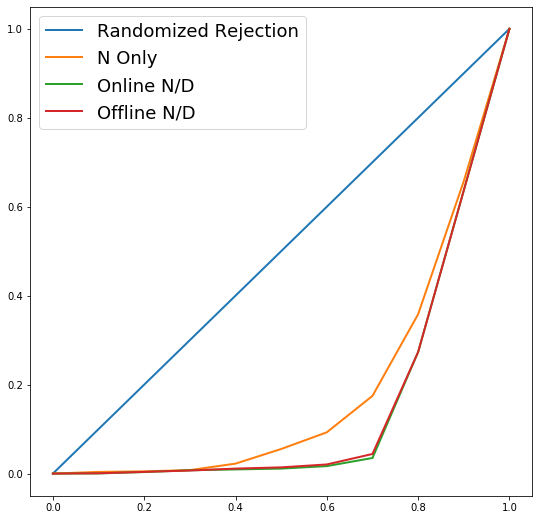

In [7]:
graphP, P_tpr = calculateFalsePositives(agt_normals, agt_attacks, userScoreP, percentages, num)
graphPQ_online, onlinePQ_tpr = calculateFalsePositives(agt_normals, agt_attacks, userScorePQ_online, percentages, num)
graphPQ_offline, offlinePQ_tpr  = calculateFalsePositives(agt_normals, agt_attacks, userScorePQ_offline, percentages, num)
graphQonline, _ = calculateFalsePositives(agt_normals, agt_attacks, userScoreQonline, percentages, num)
graphQoffline, _ = calculateFalsePositives(agt_normals, agt_attacks, userScoreQoffline, percentages, num)   

graphP.insert(0, 0)
graphPQ_online.insert(0, 0)
graphPQ_offline.insert(0, 0)
# graphQonline.insert(0, 0)
# graphQoffline.insert(0, 0)

plotAndSaveGraph(graphPQ_online, graphP, graphPQ_offline, graphQonline, graphQoffline, config) #, plt=True)

In [8]:
print(graphP[5:7])
print(graphPQ_online[5:7])
print(graphPQ_offline[5:7])

[0.05522804840210983, 0.09277071051815079]
[0.011169717654359293, 0.016754576481538937]
[0.013962147067949116, 0.020477815699658702]


In [9]:
print(P_tpr[5:7])
print(onlinePQ_tpr[5:7])
print(offlinePQ_tpr[5:7])

[0.957443780244805, 0.9313163352446017]
[0.9923142613151152, 0.986214468708064]
[0.9906063193851409, 0.9826765889959741]


### Calculate evaluation metrics 

In [10]:
def calc_eval(fpr, tpr):
    fpr = np.array(fpr[1:])
    tpr = np.array(tpr)

    Total = len(agt_normals)+len(agt_attacks) #len(userScoreP)
    TotalN = len(agt_normals)
    TotalP = Total-TotalN
    FP = fpr*TotalN
    TN = TotalN - FP
    TP = tpr*TotalP
    FN = TotalP-TP
    
    Accr = (TP+TN) / (TP+TN+FP+FN)
    FPR = FP / (FP + TN)
    Prec = TP / (TP + FP)
    Rec = TP / (TP + FN)
    F1 = 2 * ((Prec*Rec) / (Prec+Rec))

    return (Accr, FPR, Prec, Rec, F1)

In [11]:
P_metrics = np.array(np.transpose(calc_eval(graphP, P_tpr)))
onlinePQ_metrics = np.array(np.transpose(calc_eval(graphPQ_online, onlinePQ_tpr)))
offlinePQ_metrics = np.array(np.transpose(calc_eval(graphPQ_offline, offlinePQ_tpr)))

In [12]:
P_metrics = pd.DataFrame(P_metrics, columns=['Accr_P', 'FPR_P', 'Prec_P', 'Rec_P', 'F1_P'])
onlinePQ_metrics = pd.DataFrame(onlinePQ_metrics, columns=['Accr_onPQ', 'FPR_onPQ', 
                                                           'Prec_onPQ', 'Rec_onPQ', 'F1_onPQ'])
offlinePQ_metrics = pd.DataFrame(offlinePQ_metrics, columns=['Accr_offPQ', 'FPR_offPQ', 
                                                             'Prec_offPQ', 'Rec_offPQ', 'F1_offPQ'])
df_FPresults = pd.concat([P_metrics,onlinePQ_metrics,offlinePQ_metrics],axis=1)

# df_FPresults.to_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + 
#                     "_FP_finalresults.csv", index=False)